In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams

rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs
%matplotlib inline


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df


In [2]:
# define a single block to figure things out with:
# this step creates block_collection - a list of BlockSync objects of interest
#block_numbers = range(40,60)
#block_numbers = [23,24,25,26,27,35,38,39,40,41]
#block_numbers = [7,8,9,10,11,13]
block_numbers = [7]
#bad_blocks = [42, 61, 62, 64, 65, 66] # True for PV_62
bad_blocks = [0]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_126'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b

instantiated block number 007 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_007, new OE version
Found the sample rate for block 007 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 007
got it!


In [3]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 007 has a parsed events file, reading...
getting eye brigtness values for block 007...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


In [4]:
# saccade detection and annotation: 
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=True,
                                                               magnitude_calib=block.L_pix_size)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.R_pix_size)


75it [00:00, 747.83it/s]

PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


965it [00:01, 743.46it/s]
950it [00:01, 752.60it/s]


In [5]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}
        
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')
        
    return

for block in block_collection:
    block_get_lizard_movement(block)

# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms
        
        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]
        
        if overlapping_mov_times.size > 0:  
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

for block in block_collection:
    label_saccade_movements(block)


path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\PV126_Trial16_wake3_2024-07-18_12-49-12\Record Node 102\analysis\recNames=block_007,Animal=PV_126\lizMov.mat
liz_mov_df created for PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


In [6]:
# this code creates the behavior_df for block 007 of animal pv_126 (manually annotated)
# Here, I look for the connection between arena video time and electrophysiological time:
block.final_sync_df['ms_axis'] = block.final_sync_df['Arena_TTL'].values / (block.sample_rate / 1000)
arena_first_frame_ep_time_ms = block.arena_vid_first_t / (block.sample_rate/1000)
arena_last_frame_ep_time_ms = block.arena_vid_last_t / (block.sample_rate/1000)
# PV_126 block_007 ONLY!!!!
raw_times = np.array([0, 132,186,200,240,270,520,795,868,1050])*2
annotations = ['stationary','explores','stationary','explores','stationary','explores','stationary','explores','stationary']
behavior_ep_times = raw_times*1000 + arena_first_frame_ep_time_ms
start_times = behavior_ep_times[:-1]
end_times = behavior_ep_times[1:]
behavior_df = pd.DataFrame.from_dict({
    'start_time':start_times/1000,
    'end_time':end_times/1000,
    'annotation':annotations
})
behavior_df

,start_time,end_time,annotation
0,17.94295,281.94295,stationary
1,281.94295,389.94295,explores
2,389.94295,417.94295,stationary
3,417.94295,497.94295,explores
4,497.94295,557.94295,stationary
5,557.94295,1057.94295,explores
6,1057.94295,1607.94295,stationary
7,1607.94295,1753.94295,explores
8,1753.94295,2117.94295,stationary


exporting to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\raw_data_plots


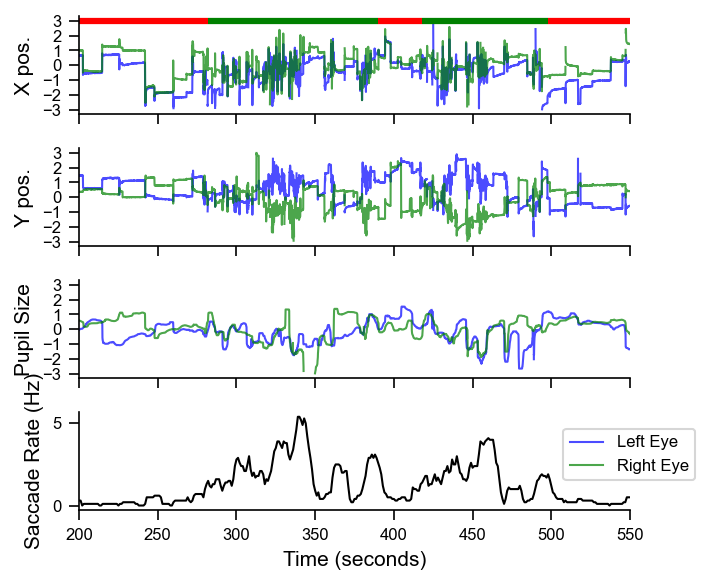

In [28]:
import matplotlib.pyplot as plt
# Reset to default settings
plt.rcdefaults()
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.signal import medfilt
import datetime
import pathlib
from matplotlib.ticker import MultipleLocator
# make pdf compatible
from matplotlib import rc
rc('pdf', fonttype=42)
from matplotlib import rcParams
# Font settings for consistency
rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8
})


def plot_zoomed_in(start_time, end_time, traces=None, left_df=None, right_df=None, outlier_threshold=3,
                   left_ms=None, right_ms=None, head_movements_ms=None, state_df=None,
                   figure_size=(15, 6), window_size=10000, bin_size=1000, export_path=None):
    """
    Plot zoomed-in eye movement data with options to display state annotations and head movements.
    
    Args:
        start_time (float): Start time in seconds for the zoomed-in region.
        end_time (float): End time in seconds for the zoomed-in region.
        traces (list, optional): List of data traces to plot. Available options: 
                                 ['center_x', 'center_y', 'pupil_diameter', 'saccade_frequency'].
        left_df (pd.DataFrame, required): Left eye data containing columns ['center_x', 'center_y', 'pupil_diameter'].
        right_df (pd.DataFrame, required): Right eye data containing columns ['center_x', 'center_y', 'pupil_diameter'].
        left_ms (array-like, required): Array of left eye saccade onset times in milliseconds.
        right_ms (array-like, required): Array of right eye saccade onset times in milliseconds.
        head_movements_ms (list, optional): List of head movement timestamps in milliseconds.
        state_df (pd.DataFrame, optional): DataFrame containing 'start_time', 'end_time', 'annotation' 
                                           to indicate the animal state (e.g., 'stationary', 'exploration').
        figure_size (tuple, optional): Size of the figure. Defaults to (15, 6).
        window_size (int, optional): Rolling window size for saccade frequency calculation in milliseconds. Defaults to 10000.
        bin_size (int, optional): Bin size for saccade frequency calculation in milliseconds. Defaults to 1000.
    """
    
    # Standardize the data
    left_df_z = left_df.apply(lambda x: zscore(x, nan_policy='omit'))
    right_df_z = right_df.apply(lambda x: zscore(x, nan_policy='omit'))

    # Convert frame numbers to milliseconds and then to seconds
    x_axis = left_df.ms_axis / 1000  # Convert to seconds

    # Filter data within the start and end time
    mask = (x_axis >= start_time) & (x_axis <= end_time)
    zoomed_x_axis = x_axis[mask]

    # Function to remove outliers
    def remove_outliers(trace, threshold=3):
        trace[np.abs(trace) > threshold] = np.nan
        return trace

    # Function to calculate saccade rate
    def calculate_saccade_rate(left_ms, right_ms, window_size=10000, bin_size=1000):
        all_saccades = np.sort(np.unique(np.concatenate((left_ms, right_ms))))
        time_bins = np.arange(start_time * 1000, end_time * 1000 + bin_size, bin_size)
        saccade_count = np.zeros_like(time_bins, dtype=float)
        

        for i in range(len(time_bins)):
            start_time_bin = time_bins[i] - window_size
            end_time_bin = time_bins[i]
            
            saccade_count[i] = np.sum((all_saccades >= start_time_bin) & (all_saccades <= end_time_bin))
        
        # Convert to rate (saccades per second)
        saccade_rate = saccade_count / (window_size / 1000)
        return time_bins, saccade_rate

    # Calculate saccade rate
    time_bins, saccade_rate = calculate_saccade_rate(left_ms, right_ms, window_size, bin_size)

    # Filter time bins and saccade rate within the zoom window
    saccade_mask = (time_bins / 1000 >= start_time) & (time_bins / 1000 <= end_time)
    zoomed_time_bins = time_bins[saccade_mask] / 1000  # Convert from ms to seconds
    zoomed_saccade_rate = saccade_rate[saccade_mask]

    # Initialize plot
    num_traces = len(traces) if traces else 0
    fig, axes = plt.subplots(nrows=num_traces, ncols=1, figsize=figure_size, sharex=True, dpi=150)

    if not isinstance(axes, np.ndarray):
        axes = [axes]  # Ensure axes is always iterable

    for i, trace in enumerate(traces):
        if trace == 'center_x':
            axes[i].plot(zoomed_x_axis, remove_outliers(left_df_z['center_x'][mask], outlier_threshold), 
                         label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, remove_outliers(right_df_z['center_x'][mask], outlier_threshold), 
                         label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('X pos.')
            # Set y-limits and ticks

            # Set the y-limits based on the outlier threshold plus 0.3
            axes[i].set_ylim(-outlier_threshold - 0.3, outlier_threshold + 0.3)
            # Use MultipleLocator to set the major ticks at whole number intervals (e.g., every 1 unit)
            axes[i].yaxis.set_major_locator(MultipleLocator(1))

        elif trace == 'center_y':
            axes[i].plot(zoomed_x_axis, remove_outliers(left_df_z['center_y'][mask], outlier_threshold), 
                         label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, remove_outliers(right_df_z['center_y'][mask], outlier_threshold), 
                         label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Y pos.')
            # Set y-limits and ticks
            # Set the y-limits based on the outlier threshold plus 0.3
            axes[i].set_ylim(-outlier_threshold - 0.3, outlier_threshold + 0.3)
            # Use MultipleLocator to set the major ticks at whole number intervals (e.g., every 1 unit)
            axes[i].yaxis.set_major_locator(MultipleLocator(1))
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'pupil_diameter':
            axes[i].plot(zoomed_x_axis, remove_outliers(medfilt(left_df_z['pupil_diameter'],121)[mask], outlier_threshold), 
                         label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, remove_outliers(medfilt(right_df_z['pupil_diameter'],121)[mask], outlier_threshold), 
                         label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Pupil Size')
            # Set y-limits and ticks
            axes[i].set_ylim(-outlier_threshold - 0.3, outlier_threshold + 0.3)
            axes[i].set_yticks([-outlier_threshold - 0.3, 0, outlier_threshold + 0.3])

            # Set the y-limits based on the outlier threshold plus 0.3
            axes[i].set_ylim(-outlier_threshold - 0.3, outlier_threshold + 0.3)
            # Use MultipleLocator to set the major ticks at whole number intervals (e.g., every 1 unit)
            axes[i].yaxis.set_major_locator(MultipleLocator(1))
            axes[i].set_xlim(left=start_time, right=end_time)
        elif trace == 'saccade_frequency':
            # For saccade frequency, we keep custom styling
            axes[i].plot(zoomed_time_bins, zoomed_saccade_rate, label='Saccade Rate', color='black', linewidth=1)
            axes[i].set_ylabel('Saccade Rate (Hz)')
        
            # Ensure the x and y ranges start from zero
            # axes[i].set_ylim(bottom=0)
            # if start_time == 0:
            #     axes[i].set_xlim(left=0)
            # 
            # # Move the spines to the origin
            # axes[i].spines['left'].set_position('zero')
            # axes[i].spines['bottom'].set_position('zero')
        
            # Hide the top and right spines
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
        
            # Adjust ticks to show them on the bottom and left only
            axes[i].xaxis.set_ticks_position('bottom')
            axes[i].yaxis.set_ticks_position('left')
            # axes[i].axhline(y=start_time, color='black', linewidth=1)
            # axes[i].axvline(x=start_time, color='black', linewidth=1)
            axes[i].set_xlim(left=start_time, right=end_time)
        
        # Add a common xlabel for the last axis
        if i == num_traces - 1:
            axes[i].set_xlabel('Time (seconds)')
            axes[i].tick_params(axis='x', which='major', length=5, color='black')
    
    # Add vertical lines for head movements if provided
    if head_movements_ms is not None:
        for ts in head_movements_ms:
            if start_time <= ts / 1000 <= end_time:
                axes[0].axvline(x=ts / 1000, color='red', linestyle='--', linewidth=1)

    # Plot animal state annotations if provided
    if state_df is not None:
        for _, row in state_df.iterrows():
            if row['end_time'] >= start_time and row['start_time'] <= end_time:
                # Clip times to the zoom window
                state_start = max(row['start_time'], start_time)
                state_end = min(row['end_time'], end_time)

                # Plot a red line above for 'stationary'
                if row['annotation'] == 'stationary':
                    axes[0].hlines(y=outlier_threshold, xmin=state_start, xmax=state_end, color='red', linewidth=3)
                
                # Plot a green line below for 'exploration'
                elif row['annotation'] == 'explores':
                    axes[0].hlines(y=outlier_threshold, xmin=state_start, xmax=state_end, color='green', linewidth=3)

    
    # Minimalistic adjustments
    for ax in axes:
        ax.grid(False)  # Disable the background grid
        ax.spines['top'].set_visible(False)  # Remove the top spine
        ax.spines['right'].set_visible(False)  # Remove the right spine
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.tick_params(axis='y', which='both', length=5, color='black')  
        ax.tick_params(axis='x', which='both', length=5)
        ax.ticklabel_format(axis='y', style='plain')  # Disable scientific notation
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
    # Add a legend for the traces
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.75, 0.23))

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Adjust to make room for legend
    
    if export_path is not None:
        t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_folder = pathlib.Path(export_path) / f"{t}_single_block_eyes_plot"
        export_folder.mkdir(parents=True, exist_ok=True)
    
        # Prepare data for export
        export_data = {
            "start_time": start_time,
            "end_time": end_time,
            "traces": traces,
            "left_df": left_df,
            "right_df": right_df,
            "left_ms": left_ms,
            "right_ms": right_ms,
            "head_movements_ms": head_movements_ms,
            "state_df": state_df,
            "window_size": window_size,
            "bin_size": bin_size
        }
    
        # Save export data
        pickle_file = export_folder / "export_data.pkl"
        with open(pickle_file, "wb") as f:
            pickle.dump(export_data, f)
            
        print(f'exporting to {export_path}')
        plt.savefig(export_folder / f"{t}_single_block_eyes_plot.pdf", format='pdf')
    plt.show()


# Example usage with selected traces and state annotations
#export_path=block.analysis_path / 'eye_movement_z_scored_trace.pdf'
t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
#export_path= fr'{str(pathlib.Path.cwd())}\figures_export\{t}_locomotion_eye_movement_z_scored_trace.pdf'
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\raw_data_plots'
plot_zoomed_in(start_time=200, end_time=550, 
               traces=['center_x', 'center_y','pupil_diameter','saccade_frequency'], 
               left_df=block.left_eye_data, right_df=block.right_eye_data,
               outlier_threshold=3,
               left_ms=block.l_saccade_df.saccade_on_ms.values, right_ms=block.r_saccade_df.saccade_on_ms.values,
               head_movements_ms=None, 
               state_df=behavior_df,
               figure_size=(5, 4),export_path=export_path)

In [29]:
def reload_and_plot_zoomed_in(pickle_folder_path, start_time=None, end_time=None, traces=None, 
                              figure_size=None, export_path=None):
    """
    Reload data from a pickle file and call the original plot_zoomed_in function.

    Args:
        pickle_folder_path (str or pathlib.Path): Path to the folder containing the export_data.pkl file.
        start_time (float, optional): Start time override in seconds.
        end_time (float, optional): End time override in seconds.
        traces (list, optional): List of data traces to plot. Default to the traces from the file.
        figure_size (tuple, optional): Figure size override.
        export_path (str or pathlib.Path, optional): Path to export the new plot.
    """
    pickle_file = pathlib.Path(pickle_folder_path) / "export_data.pkl"

    # Load the data from the pickle file
    if not pickle_file.exists():
        print(f"Error: {pickle_file} not found!")
        return

    with open(pickle_file, "rb") as f:
        export_data = pickle.load(f)

    # Override settings if provided
    start_time = start_time if start_time is not None else export_data["start_time"]
    end_time = end_time if end_time is not None else export_data["end_time"]
    traces = traces if traces is not None else export_data["traces"]
    figure_size = figure_size if figure_size is not None else (15, 6)


    # Call the original plotting function
    plot_zoomed_in(
        start_time=start_time,
        end_time=end_time,
        traces=traces,
        left_df=export_data["left_df"],
        right_df=export_data["right_df"],
        left_ms=export_data["left_ms"],
        right_ms=export_data["right_ms"],
        head_movements_ms=export_data["head_movements_ms"],
        state_df=export_data["state_df"],
        figure_size=figure_size,
        export_path=export_path,
        window_size=export_data["window_size"],
        bin_size=export_data["bin_size"]
    )

    print(f"Plot recreated using data from: {pickle_folder_path}")

exporting to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\raw_data_plots\2024_12_15_18_39_single_block_eyes_plot


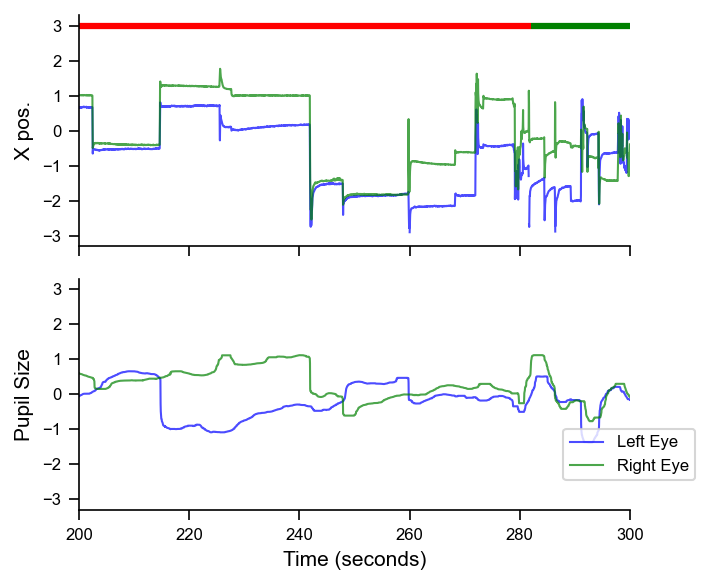

Plot recreated using data from: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\raw_data_plots\2024_12_15_18_39_single_block_eyes_plot


In [31]:
pickle_folder = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\raw_data_plots\2024_12_15_18_39_single_block_eyes_plot'
reload_and_plot_zoomed_in(pickle_folder,start_time=200,end_time=300, traces=['center_x', 'pupil_diameter'], figure_size=(5, 4))
